# Attention 모델 불러오기

# 학습 모델을 사용하여 대답 예측하기

In [2]:
import tensorflow as tf
tf.enable_eager_execution()  # tf v1에 필요, 만약 v2라면 주석처리 합니다.

from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model

import re
import numpy as np

import pickle

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

### 단어사전과 학습시킨 모델 불러오기
- 단어사전: 학습에서 사용한 단어사전을 불러옵니다.

- 학습시킨 인코더모델과 디코더모델을 불러옵니다.

In [101]:
# 단어 사전 불러오기

with open('attention_word_to_index.pickle', 'rb') as handle:
    word_to_index = pickle.load(handle)
with open('attention_index_to_word.pickle', 'rb') as handle:
    index_to_word = pickle.load(handle)

In [102]:
# 학습한 모델 불러오기 (인코더, 디코더)

def load_model(model_filename, model_weights_filename):
    with open(model_filename, 'r', encoding='utf8') as f:
        model = model_from_json(f.read())
    model.load_weights(model_weights_filename)
    return model

encoder_model = load_model('attention_encoder_model.json', 'attention_encoder_model_weights.h5')
decoder_model = load_model('attention_decoder_model.json', 'attention_decoder_model_weights.h5')

### 학습시 사용한 파라미터와 모델 예측에 사용할 함수 정의

In [6]:
# 파라미터 

PAD = "<PADDING>"   # 패딩
STA = "<START>"     # 시작
END = "<END>"       # 끝
OOV = "<OOV>"       # 없는 단어(Out of Vocabulary)

# 태그 인덱스
PAD_INDEX = 0
STA_INDEX = 1
END_INDEX = 2
OOV_INDEX = 3

# 데이터 타입
ENCODER_INPUT  = 0
DECODER_INPUT  = 1
DECODER_TARGET = 2

# 한 문장에서 단어 시퀀스의 최대 개수
max_sequences = 20


# 임베딩 벡터 차원
embedding_dim = 200

In [7]:
# 형태소 분석기 Mecab 사용

import MeCab

mecab = MeCab.Tagger()
def mecab_morphs(text):
    morphs = []
    # 우리가 원하는 TOKEN\tPOS의 형태를 추출하는 정규표현식.
    pattern = re.compile(".*\t[A-Z]+") 
    # 패턴에 맞는 문자열을 추출하여 konlpy의 mecab 결과와 같아지도록 수정.
    temp = [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]]
    # 추출한 token중에 문자열만 선택.
    for token in temp:
        morphs.append(token[0])
    return morphs

In [8]:
# 정규표현식으로 특수기호 제거하고 토근화하는 함수 정의

def pos_tag_korea(sentences):
    # KoNLPy 형태소분석기 설정
    # 문장 품사 변수 초기화
    sentences_pos = []
    # 모든 문장 반복
    for sentence in sentences:
        # 특수기호 제거
        RE_FILTER = re.compile("[!#$%&()*+,-/:;<=>@[\\]^_`{|}~]")
        sentence = re.sub(RE_FILTER, "", sentence)     
        # 배열인 형태소분석의 출력을 띄어쓰기로 구분하여 붙임
        sentence = " ".join(mecab_morphs(sentence))
        sentences_pos.append(sentence)
    return sentences_pos

In [79]:
# 모델을 사용하여 대답 문장을 예측하는 함수

def generate_text(input_seq):
    ## 입력을 인코더에 넣어 마지막 상태 구함
    # states = encoder_model.predict(input_seq)

    # 입력을 인코더에 넣어 마지막 상태 구함
    H, h, c = encoder_model.predict(input_seq)
    states=[h,c]
    # 목표 시퀀스 초기화
    target_seq = np.zeros((1, 1))
    
    # 목표 시퀀스의 첫 번째에 <START> 태그 추가
    target_seq[0, 0] = STA_INDEX
    
    # 인덱스 초기화
    indexs = []
    
    # 디코더 타임 스텝 반복
    while 1:
        # 디코더로 현재 타임 스텝 출력 구함
        # 처음에는 인코더 상태를, 다음부터 이전 디코더 상태로 초기화
        decoder_outputs, h, c, _ = decoder_model.predict(
                                                [target_seq] + [H,h,c])

        # 결과의 원핫인코딩 형식을 인덱스로 변환
        index = np.argmax(decoder_outputs[0, 0, :])
        indexs.append(index)
        
        # 종료 검사
        if index == END_INDEX or len(indexs) >= max_sequences:
            break

        # 목표 시퀀스를 바로 이전의 출력으로 설정
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = index
        
        # 디코더의 이전 상태를 다음 디코더 예측에 사용
        # states = [state_h, state_c]

    # 인덱스를 문장으로 변환
    sentence = convert_index_to_text(indexs, index_to_word)
    
    return sentence


In [10]:
# 인덱스를 문장으로 변환
def convert_index_to_text(indexs, vocabulary): 
    sentence = ''
    # 모든 문장에 대해서 반복
    for index in indexs:
        if index == END_INDEX:
            # 종료 인덱스면 중지
            break;
        if vocabulary.get(index) is not None:
            # 사전에 있는 인덱스면 해당 단어를 추가
            sentence += vocabulary[index]
        else:
            # 사전에 없는 인덱스면 OOV 단어를 추가
            sentence.extend([vocabulary[OOV_INDEX]])

        # 빈칸 추가
        sentence += ' '

    return sentence

In [11]:
## 문장 속 형태소(단어)를 벡터로 변경하는 함수 작성
def convert_text_to_index(sentences, vocabulary,type): 
    
    sentences_index = []
    
    # 모든 문장에 대해서 반복
    for sentence in sentences:
        sentence_index = []

        # 디코더 입력일 경우 맨 앞에 START 태그 추가
        if type == DECODER_INPUT:
            sentence_index.extend([vocabulary[STA]])
        
        # 문장의 단어들을 띄어쓰기로 분리
        for word in sentence.split():
            if vocabulary.get(word) is not None:
                # 사전에 있는 단어면 해당 인덱스를 추가
                sentence_index.extend([vocabulary[word]])
            else:
                # 사전에 없는 단어면 OOV 인덱스를 추가
                sentence_index.extend([vocabulary[OOV]])

        # 최대 길이 검사
        if type == DECODER_TARGET:
            # 디코더 목표일 경우 맨 뒤에 END 태그 추가
            if len(sentence_index) >= max_sequences:
                sentence_index = sentence_index[:max_sequences-1] + [vocabulary[END]]
            else:
                sentence_index += [vocabulary[END]]
        else:
            if len(sentence_index) > max_sequences:
                sentence_index = sentence_index[:max_sequences]
            
        # 최대 길이에 없는 공간은 패딩 인덱스로 채움
        sentence_index += (max_sequences - len(sentence_index)) * [vocabulary[PAD]]
        
        # 문장의 인덱스 배열을 추가
        sentences_index.append(sentence_index)

    return np.asarray(sentences_index)

In [12]:
# 예측을 위한 입력 데이터 처리하기 
# 한글을 형태소 분석 한 뒤, 벡터 배열로 변경하는 함수

def make_predict_input(sentence):
    sentences = []
    sentences.append(sentence)
    sentences = pos_tag_korea(sentences)
    input_seq = convert_text_to_index(sentences, word_to_index,ENCODER_INPUT)
    
    return input_seq

In [28]:
# 띄어쓰기를 붙이기
# 임시로 해놓은거라 완벽하지 않습니다..

josa_low = [' 은 ',' 는 ',' 을 ',' 를 ',' 이 ',' 가 ',' 에 ',' 랑 ',' 와 ',' 과 ',' 고 ',' 었 ',' 했 ',' 았 ',' 겠 ',' 요 ',' 어 ', ' 도 ',' 에게 ', ' 께 ',' 의 ',' 지 ',' 만 ',' 지만 ', ' 다니 ',' 할 ',' 날 ',' 땐 ',' 라도 ',' 건 ']
josa_high = [' 에요 ',' 어요 ',' 네요 ',' 세요 ',' 아요 ',' 예요 ',' 으셔도 ',' 죠 ',' 으시 ',' 군요 ']
end_josa=[' 다 ',' 내 ',' 야 ', ' 아 ', ' 봐 ',' 지 ']
josa2=[' 거야 ',' 으면 ',' 하고 ']
end = [' ? ']
def removeSpacing(s):
    josa = josa_low + josa_high + end
    for i in range(len(josa)):
        s = s.replace(josa[i],josa[i][1:])
    if s[-3:] in end_josa:
        s = s[:-3] + s[-2:]
    for i in range(len(josa2)):
        s = s.replace(josa2[i],josa2[i][1:])
    return s

### 대답 예측하기

In [110]:
korean_sentence='가끔 궁금해'

input_seq = make_predict_input(korean_sentence)
answer = generate_text(input_seq)
removeSpacing(answer)

'그 사람도 그럴 거예요 '

# 참고1. Attention 가중치 시각화하기
예측한 문장에 대해서 attention 가중치를 확인하고 싶다면 아래의 코드를 참고하세요.

시각화 그래프에 한글을 사용하려면, 한글 글꼴을 다운받아야 합니다.

(http://corazzon.github.io/matplotlib_font_setting 여기를 참고하여 다운받아줍니다.)

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
font_path = 'C:/Windows/Fonts/NanumBarunGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=18) 

In [17]:
# 텍스트 생성
def evaluate(input_sentence):
    attention_plot = np.zeros((max_sequences, max_sequences))
    
    sentences = []
    sentences.append(input_sentence)
    sentences = pos_tag_korea(sentences)
    input_sentence = sentences[0]
    input_seq = convert_text_to_index(sentences, word_to_index,ENCODER_INPUT)

    # 입력을 인코더에 넣어 마지막 상태 구함
    H, h, c = encoder_model.predict(input_seq)
    states=[h,c]
    # 목표 시퀀스 초기화
    target_seq = np.zeros((1, 1))
    
    # 목표 시퀀스의 첫 번째에 <START> 태그 추가
    target_seq[0, 0] = STA_INDEX
    
    # 인덱스 초기화
    indexs = []
    
    # 디코더 타임 스텝 반복
    i = 0
    while 1:
        # 디코더로 현재 타임 스텝 출력 구함
        # 처음에는 인코더 상태를, 다음부터 이전 디코더 상태로 초기화
        decoder_outputs, h, c, att_weights = decoder_model.predict(
                                                [target_seq] + [H,h,c])

        # 결과의 원핫인코딩 형식을 인덱스로 변환
        index = np.argmax(decoder_outputs[0, 0, :])
        indexs.append(index)
        
        # 종료 검사
        if index == END_INDEX or len(indexs) >= max_sequences:
            break

        # 목표 시퀀스를 바로 이전의 출력으로 설정
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = index
        
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(att_weights, (-1, ))
        attention_plot[i] = attention_weights.numpy()
        i += 1
        
    # 인덱스를 문장으로 변환
    sentence = convert_index_to_text(indexs, index_to_word)
    
    return sentence, input_sentence, attention_plot

In [18]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 20}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90, fontproperties=fontprop)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties=fontprop)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [19]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))
  result = result.strip()
  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

['슬슬', '배고파']
Input: 슬슬 배고파
Predicted translation: 간식 이 라도 챙겨 드세요 


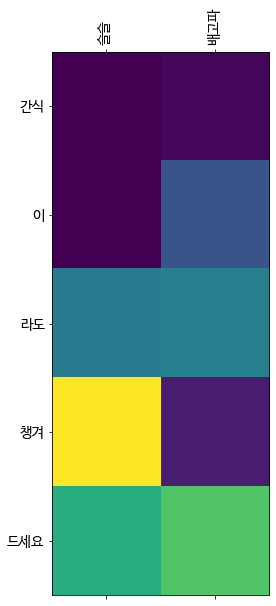

['너무', '배고프', '다']
Input: 너무 배고프 다
Predicted translation: 간식 이 라도 챙겨 드세요 


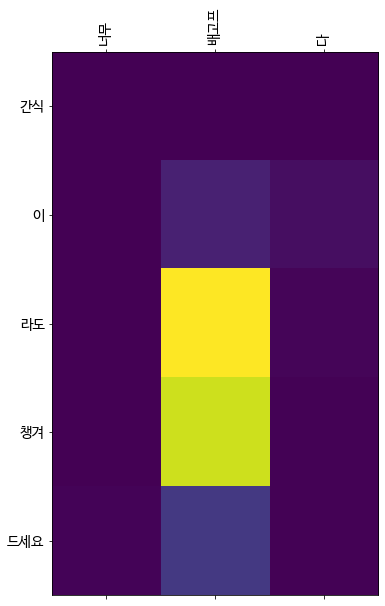

['배고프', '다']
Input: 배고프 다
Predicted translation: 간식 을 드 시 는 건 어떨까 요 ? 


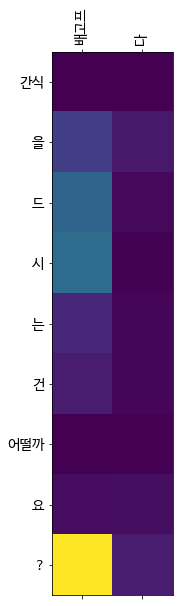

['벌써', '배고파']
Input: 벌써 배고파
Predicted translation: 간식 이 라도 챙겨 드세요 


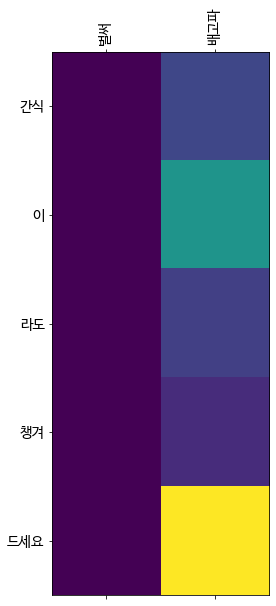

['배고파']
Input: 배고파
Predicted translation: 뭐 좀 챙겨 드세요 


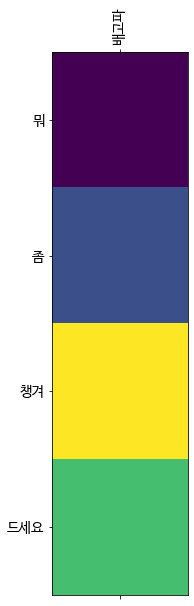

['안녕']
Input: 안녕
Predicted translation: 안녕 하 세요 


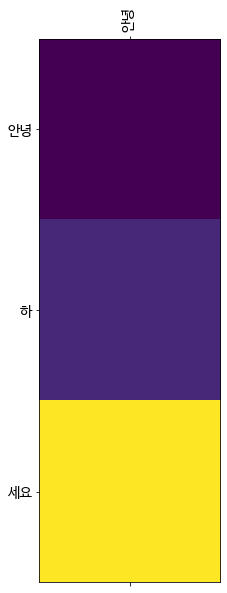

['넌', '누구', '니', '?']
Input: 넌 누구 니 ?
Predicted translation: 저 는 위 로 봇 입니다 


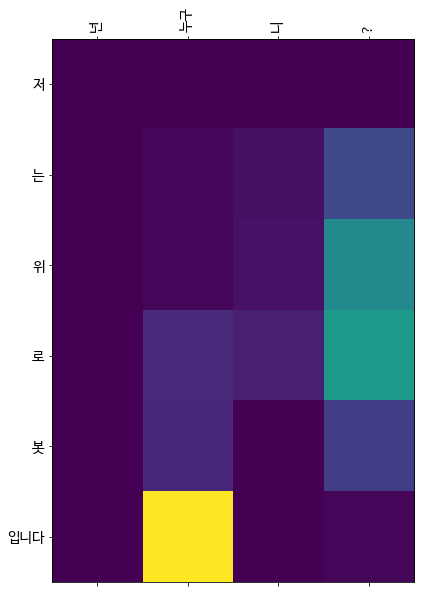

['피곤', '하', '다']
Input: 피곤 하 다
Predicted translation: 휴식 을 갖 는 건 어떠세요 ? 


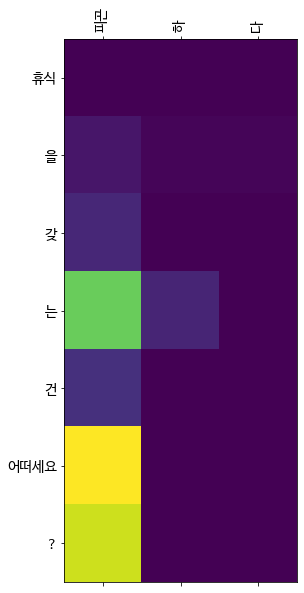

['심심', '하', '다']
Input: 심심 하 다
Predicted translation: 저 랑 놀 아요 


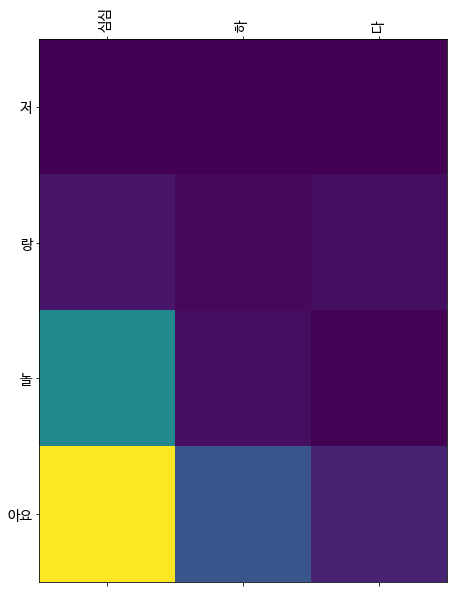

['뭐', '먹', '을까', '?']
Input: 뭐 먹 을까 ?
Predicted translation: 오늘 은 짜장면 어떠세요 ? 


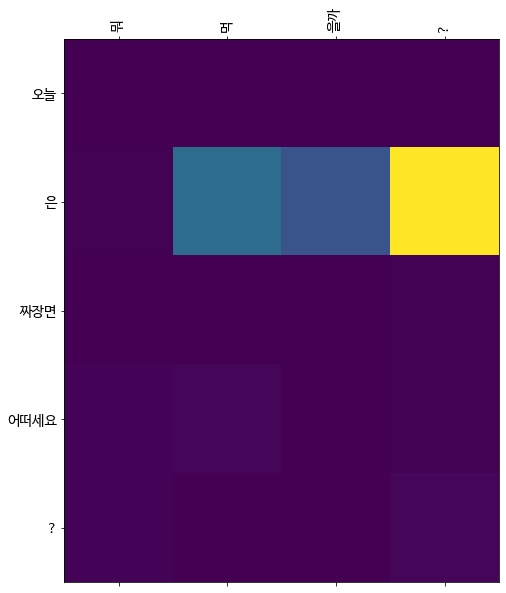

['점심', '뭐', '먹', '지', '?']
Input: 점심 뭐 먹 지 ?
Predicted translation: 오늘 은 짜장면 어떠세요 ? 


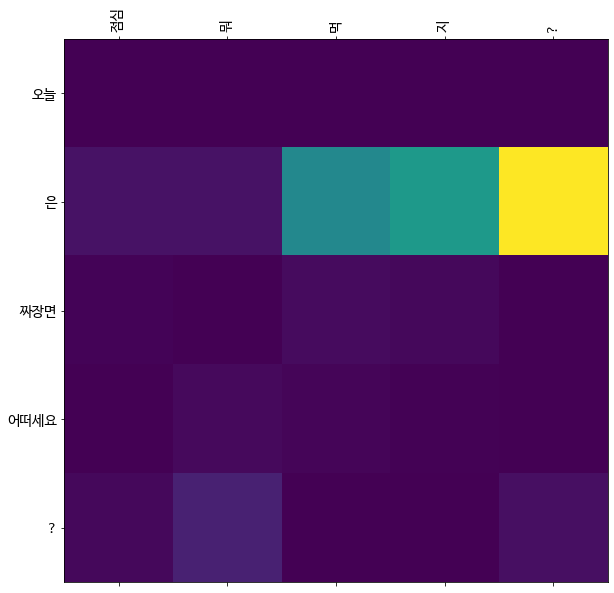

['퇴근', '이', '다']
Input: 퇴근 이 다
Predicted translation: 오늘 하루 도 수고 하 셨 어요 


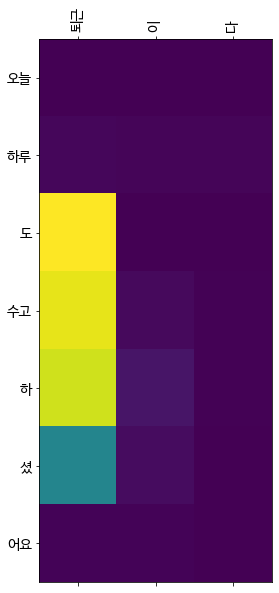

In [66]:
# attention 예시입니다. 핵심 단어가 있는 열에 색상이 밝은 것을 볼 수 있습니다.

li = ['슬슬 배고파','너무 배고프다', '배고프다','벌써 배고파','배고파','안녕','넌 누구니?','피곤하다','심심하다','뭐 먹을까?','점심 뭐 먹지?','퇴근이다']

for s in li:
    translate(s)

# 참고2. Encoder 모델의 context 벡터 시각화
google의 Embedding Projector를 사용하여 context벡터를 시각화할 수 있습니다.

(https://projector.tensorflow.org/)

In [20]:
# 인코더 모델을 통해 context 벡터 추출하기

def encoderOutput(x):
    x = make_predict_input(x)
    H, h, c = encoder_model(x)
    encoder_output= H.numpy()
    return encoder_output[0]

In [21]:
# 몇가지 예제 질문

li = ['안녕','넌 누구니?','피곤하다','뭐 먹을까?','점심 뭐 먹지?','퇴근이다','피곤해','피곤하다','오늘따라 더 피곤하다','오늘 일이 너무 많아서 피곤하다','어제 잠을 많이 못 잤더니 피곤하다','배부르다','엄마한테 혼나서 심란하다','어제 친구랑 싸웠는데 화해를 못해서 심란해',
      '어제 공부를 열심히 했더니 피곤하다','내가 심란해하는 모습을 보는건 나도 싫어','부모님이 힘들어허시는 걸 보니 나도 심란해','심란한 기분을 떨쳐버리고 싶어','어제부터 내가 너무 우울해서 부모님의 기분도 심란해','하루종일 집에 있었더니 마음이 심란해진 것 같아','요즘 재미있는 일이 많아서 행복해',
      '난 행복한 사람이야','행복해하는 사람들을 보면 기분이 우울해져','행복해지려면 뭘 해야해?','요즘따라 왜이리 우울하지?','우울한 감정을 벗어나려면 어떻게 해야해?','사람들이 나를 싫어하는 것 같아서 우울해']

In [22]:
vector=[]  # context벡터를 저장할 리스트

for x in li:
    vector.append(encoderOutput(x).reshape(-1,))

In [24]:
# 문장에 대한 context vector를 텍스트파일로 저장하기

vector = np.array(vector)
np.savetxt( 'vector.txt', vector, fmt='%f', delimiter='\t')
print(vector.shape)

(27, 2560)


In [25]:
def write_txt(li, fname, sep):
    file = open(fname,'w')
    vstr = ''
    for a in li:
        vstr = vstr + str(a) + sep
    vstr = vstr.rstrip(sep)
    file.writelines(vstr)
    file.close()
    print('파일저장완료')

In [189]:
def encoderOutput(x):
    x = make_predict_input(x)
    H, h, c = encoder_model(x)
    encoder_output= H.numpy()
    return encoder_output[0]

In [455]:
# '슬슬 배고파','너무 배고프다', '배고프다','벌써 배고파' > 간식 이 라도 챙겨 드세요 
# 점심 뭐먹지? 뭐 먹을까? > '오늘 은 짜장면 어떠세요 ? '
li = ['안녕','넌 누구니?','피곤하다','뭐 먹을까?','점심 뭐 먹지?','퇴근이다','피곤해','피곤하다','오늘따라 더 피곤하다','오늘 일이 너무 많아서 피곤하다','어제 잠을 많이 못 잤더니 피곤하다','배부르다','엄마한테 혼나서 심란하다','어제 친구랑 싸웠는데 화해를 못해서 심란해',
      '어제 공부를 열심히 했더니 피곤하다','내가 심란해하는 모습을 보는건 나도 싫어','부모님이 힘들어허시는 걸 보니 나도 심란해','심란한 기분을 떨쳐버리고 싶어','어제부터 내가 너무 우울해서 부모님의 기분도 심란해','하루종일 집에 있었더니 마음이 심란해진 것 같아','요즘 재미있는 일이 많아서 행복해',
      '난 행복한 사람이야','행복해하는 사람들을 보면 기분이 우울해져','행복해지려면 뭘 해야해?','요즘따라 왜이리 우울하지?','우울한 감정을 벗어나려면 어떻게 해야해?','사람들이 나를 싫어하는 것 같아서 우울해']

In [456]:
vector=[]
for x in li:
    vector.append(encoderOutput(x).reshape(-1,))

In [457]:
vector = np.array(vector)
np.savetxt( 'vector.txt', vector, fmt='%f', delimiter='\t')
vector.shape

(27, 3840)

In [27]:
# 문장을 텍스트파일로 저장하기
write_txt(li, 'meta.txt', sep='\n')

파일저장완료


# 참고3. 모델 평가하기 

### 1) 테스트 셋

In [150]:
import pandas as pd
df = pd.read_csv('./all_data.csv')
df.head()

,Q,A,data
0,12시 땡!,하루가 또 가네요.,2
1,1지망 학교 떨어졌어,위로해 드립니다.,2
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,2
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,2
4,PPL 심하네,눈살이 찌푸려지죠.,2


In [151]:
# 테스트 셋 x,y 나누기
test_df=df[:30]
test_X = test_df['Q'].values
test_y = test_df['A'].values
test_X[:10]

array(['12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다',
       'PPL 심하네', 'SD카드 망가졌어', 'SD카드 안돼', 'SNS 맞팔 왜 안하지ㅠㅠ',
       'SNS 시간낭비인 거 아는데 매일 하는 중', 'SNS 시간낭비인데 자꾸 보게됨'], dtype=object)

In [152]:
x=pos_tag_korea(test_X)   # 전처리
x=convert_text_to_index(x,word_to_index,ENCODER_INPUT)  #index, padding 

y=pos_tag_korea(test_y)   # 전처리
y=convert_text_to_index(y,word_to_index,ENCODER_INPUT)  #index, padding 
y

array([[ 14,  46,  36,  46, 124,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [ 97,  78, 121,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  7,  67,  28,  61, 105,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  7,  67,  28,  61, 105,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [106,  70, 111,  59, 105,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [ 71,  18,  60, 127,  48,  92,  23,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [ 71,  18,  60, 127,  48,  92,  23,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [ 53,  39,  20,  21,  55,  40,  19,  21,  29,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [ 49,  55,  35,  20,  78,  75,  65,   0,   0,   0,   0,  

### 2) 워드 임베딩

In [153]:
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.models import Sequential

vocab_len= len(word_to_index)
embedding_dim = 200

# 임베딩 모델 
emb_model = Sequential()
emb_model.add(Embedding(vocab_len, embedding_dim, input_length=20 , name='de-embedding'))

# 가중치 로드하기
emb_model.load_weights('attention_decoder_model_weights.h5', by_name=True)

In [154]:
# y(정답데이터) 임베딩하기
y_emb = emb_model.predict(y)
print(y_emb.shape)
y_emb

(30, 20, 200)


array([[[ 0.01448477,  0.04890775,  0.0056952 , ...,  0.03835274,
          0.03368158,  0.02174748],
        [-0.03639406,  0.02725026,  0.03120701, ..., -0.02489701,
         -0.03537275,  0.01355806],
        [ 0.0290329 ,  0.04104965, -0.0212679 , ..., -0.01988973,
         -0.04826305, -0.03286027],
        ...,
        [-0.02423068, -0.03456415,  0.02420667, ..., -0.02109983,
          0.01890719, -0.03975426],
        [-0.02423068, -0.03456415,  0.02420667, ..., -0.02109983,
          0.01890719, -0.03975426],
        [-0.02423068, -0.03456415,  0.02420667, ..., -0.02109983,
          0.01890719, -0.03975426]],

       [[-0.01037131,  0.04458893,  0.0330969 , ...,  0.0138065 ,
         -0.0499642 ,  0.00494623],
        [-0.02453363, -0.02332468, -0.00627757, ..., -0.01942611,
         -0.02736604,  0.00156481],
        [-0.00642211, -0.01102992, -0.01741806, ...,  0.02789868,
          0.02045396, -0.0083345 ],
        ...,
        [-0.02423068, -0.03456415,  0.02420667, ..., -

### 3) 예측하기

In [155]:
# test셋 예측값을 (단어 임베딩된 상태의) 리스트로 출력

def predict(x_set):
    y_pred = []
#     # 전처리
#     x_set=convert_text_to_index(x_set,word_to_index)
    # 예측하기
    for x in x_set:
        x = make_predict_input(x)
        pred_text = generate_text(x)
        y_pred.append(pred_text)        
    y_pred = convert_text_to_index(y_pred,word_to_index,ENCODER_INPUT)
    # 임베딩:(100,20) 인덱스 형태> (100,20,100)
    y_pred = emb_model.predict(y_pred)
    return y_pred

In [156]:
y_pred_emb = predict(test_X)
y_pred_emb.shape

(30, 20, 200)

### 4) MSE

In [157]:
from sklearn.metrics import mean_squared_error

# 단어 임베딩 상태로 들어온다면
def model_mse(y, y_pred):
    # 3차원 > 2차원으로
    y = y.reshape(y.shape[0],-1)
    y_pred = y_pred.reshape(y_pred.shape[0],-1)
    # (y, y_pred) 각 2차원인 벡터 임베딩된 시퀀스가 들어감.
    return mean_squared_error(y, y_pred)

In [158]:
# mse 구하기
model_mse(y_emb,y_pred_emb)

0.00033724215

### 5) MAPE

In [159]:
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [160]:
MAPE(y_emb,y_pred_emb)

84.30887460708618